In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
pd.set_option("display.max_rows", 60, "display.max_columns", 60)

In [3]:
sc.settings.verbosity = 3            
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.1 scipy==1.7.1 pandas==1.3.1 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [4]:
results_file = "write/GSM2560245.h5ad"

In [5]:
#reading in files to anndata
adata = sc.read_10x_mtx('/mnt/disks/mount_dir/GSM2560245',var_names='gene_symbols',cache=True)

... reading from cache file cache/mnt-disks-mount_dir-GSM2560245-matrix.h5ad


In [6]:
adata.var_names_make_unique()

In [7]:
adata

AnnData object with n_obs × n_vars = 3639 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


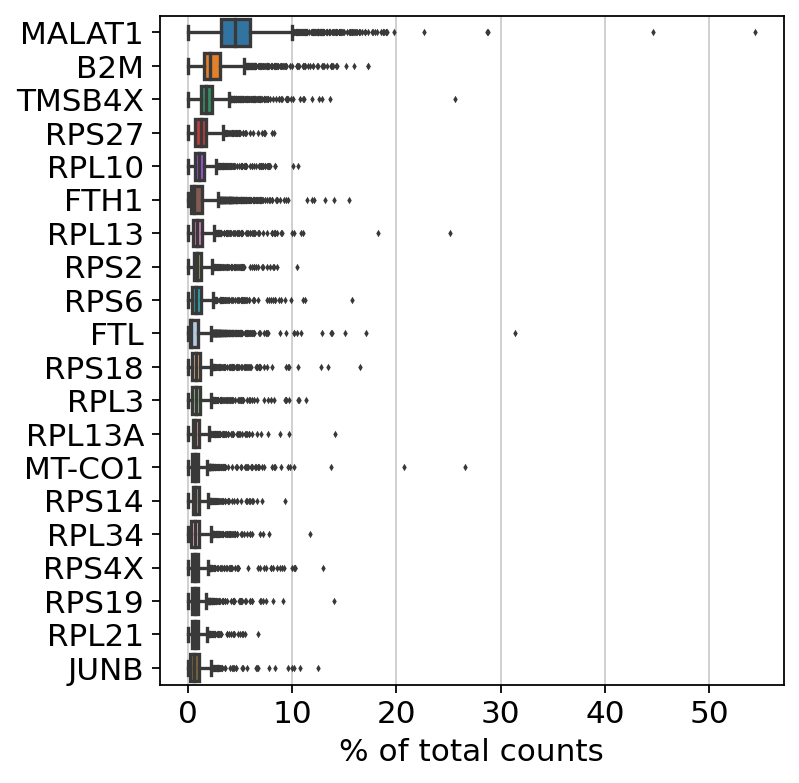

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [9]:
#reading in demuxlet results file with alpha parameter in its run
demuxlet=pd.read_csv('/mnt/disks/mount_dir/demuxlet_files/demuxlet_data_sma.csv',delimiter='\t')

In [10]:
#annotating demuxlet assignment to anndata
adata.obs['demuxlet_assignment']=demuxlet['BEST'].to_list()

In [11]:
#annotating demuxlet doublet log likelihood
adata.obs['demuxlet_DBL_llk']=demuxlet['LLK12'].to_list()

In [12]:
#reading in demuxlet results file without alpha parameter in its run
demuxlet2=pd.read_csv('/mnt/disks/mount_dir/demuxlet_files/demuxlet_data_sm.csv',delimiter='\t')

In [13]:
#annotating demuxlet without alpha assignment to anndata
adata.obs['demuxlet_assignment_2']=demuxlet2['BEST'].to_list()

In [14]:
#annotating demuxlet without alpha doublet log likelihood
adata.obs['demuxlet_DBL_llk_2']=demuxlet2['LLK12'].to_list()

In [15]:
#reading in souporcell results file
souporcell=pd.read_csv('/mnt/disks/mount_dir/soupor_out/clusters.csv', delimiter='\t')

In [16]:
#combining status of assignment and cluster assignment
souporcell['assignment'] = souporcell[['status', 'assignment']].agg('-'.join, axis=1)

In [17]:
#annotating souporcell assignment to anndata
adata.obs['souporcell_assignment']=souporcell['assignment'].to_list()

In [18]:
#annotating souporcell doublet log probability
adata.obs['souporcell_doublet_logprob']=souporcell['log_prob_doublet'].to_list()

In [19]:
#annotating simple version of demuxlet without alpha assignment
adata.obs['demuxlet_assignment_simple_2']='DBL'
demuxlet_s_2=adata.obs.loc[adata.obs['demuxlet_assignment_2'].str.startswith('SNG-1')].index.to_list()
adata.obs.loc[demuxlet_s_2,'demuxlet_assignment_simple_2'] = 'SNG'

In [20]:
#annotating simple version of demuxlet assignment
adata.obs['demuxlet_assignment_simple']='DBL'
demuxlet_s=adata.obs.loc[adata.obs['demuxlet_assignment'].str.startswith('SNG-1')].index.to_list()
adata.obs.loc[demuxlet_s,'demuxlet_assignment_simple'] = 'SNG'

In [21]:
#annotating simple version of souporcell assignment
adata.obs['souporcell_assignment_simple']='DBL'
souporcell_s=adata.obs.loc[adata.obs['souporcell_assignment'].str.startswith('singlet')].index.to_list()
adata.obs.loc[souporcell_s,'souporcell_assignment_simple'] = 'SNG'

In [22]:
#annotating combined assignments of souporcell and demuxlet, unanmously assigned singlet = SNG, 
#unanmously assigned doublet = DBL, assigned doublet just by demuxlet = demuxlet_DBL,
#assigned doublet just by souporcell = souporcell_DBL
adata.obs['demuxlet_souporcell_assignment']='SNG'
adata.obs.loc[adata.obs[(adata.obs['souporcell_assignment_simple'] == 'DBL')&(adata.obs['demuxlet_assignment_simple'] == 'DBL')].index.to_list(),'demuxlet_souporcell_assignment']='DBL'
adata.obs.loc[adata.obs[(adata.obs['souporcell_assignment_simple'] == 'SNG')&(adata.obs['demuxlet_assignment_simple'] == 'DBL')].index.to_list(),'demuxlet_souporcell_assignment']='demuxlet_DBL'
adata.obs.loc[adata.obs[(adata.obs['souporcell_assignment_simple'] == 'DBL')&(adata.obs['demuxlet_assignment_simple'] == 'SNG')].index.to_list(),'demuxlet_souporcell_assignment']='souporcell_DBL'

In [23]:
#matching singlet sample assignments of demuxlet and souporcell
SNG_1154_match=adata.obs[(adata.obs['demuxlet_assignment'] == 'SNG-1154')]['souporcell_assignment'].value_counts().to_dict()
SNG_1249_match=adata.obs[(adata.obs['demuxlet_assignment'] == 'SNG-1249')]['souporcell_assignment'].value_counts().to_dict()
SNG_1598_match=adata.obs[(adata.obs['demuxlet_assignment'] == 'SNG-1598')]['souporcell_assignment'].value_counts().to_dict()
SNG_1079_match=adata.obs[(adata.obs['demuxlet_assignment'] == 'SNG-1079')]['souporcell_assignment'].value_counts().to_dict()

In [24]:
SNG_matches=pd.DataFrame([SNG_1154_match,SNG_1249_match,SNG_1598_match,SNG_1079_match])
first_cols = ['singlet-0','singlet-1','singlet-2','singlet-3']
last_cols = [col for col in SNG_matches.columns if col not in first_cols]
SNG_matches = SNG_matches[first_cols+last_cols]

SNG_matches.index = ['sample_1154', 'sample_1249', 'sample_1598', 'sample_1079']

SNG_matches.head()

singlet-0  singlet-1  singlet-2  singlet-3  unassigned-3/2  \
sample_1154      965.0        NaN        NaN        NaN             NaN   
sample_1249        1.0        NaN        NaN      791.0             1.0   
sample_1598        NaN      790.0        NaN        NaN             NaN   
sample_1079        NaN        NaN      877.0        NaN             NaN   

             unassigned-0  doublet-1/3  doublet-2/1  unassigned-2/1  \
sample_1154           NaN          NaN          NaN             NaN   
sample_1249           NaN          NaN          NaN             NaN   
sample_1598           1.0          1.0          NaN             NaN   
sample_1079           NaN          NaN          1.0             1.0   

             unassigned-2/0  doublet-2/3  
sample_1154             NaN          NaN  
sample_1249             NaN          NaN  
sample_1598             NaN          NaN  
sample_1079             1.0          1.0

In [25]:
#annotating sample assignment by souporcell converting cluster assignment to matching sample
adata.obs['sample_assignment_s']='DBL'
adata.obs.loc[adata.obs[(adata.obs['souporcell_assignment'] == 'singlet-0')].index.to_list(),'sample_assignment_s']='1154'
adata.obs.loc[adata.obs[(adata.obs['souporcell_assignment'] == 'singlet-1')].index.to_list(),'sample_assignment_s']='1598'
adata.obs.loc[adata.obs[(adata.obs['souporcell_assignment'] == 'singlet-2')].index.to_list(),'sample_assignment_s']='1079'
adata.obs.loc[adata.obs[(adata.obs['souporcell_assignment'] == 'singlet-3')].index.to_list(),'sample_assignment_s']='1249'

In [26]:
#annotating sample assingment specific to demuxlet
adata.obs['sample_assignment_d']='DBL'
adata.obs.loc[adata.obs[(adata.obs['demuxlet_assignment'] == 'SNG-1154')].index.to_list(),'sample_assignment_d']='1154'
adata.obs.loc[adata.obs[(adata.obs['demuxlet_assignment'] == 'SNG-1598')].index.to_list(),'sample_assignment_d']='1598'
adata.obs.loc[adata.obs[(adata.obs['demuxlet_assignment'] == 'SNG-1079')].index.to_list(),'sample_assignment_d']='1079'
adata.obs.loc[adata.obs[(adata.obs['demuxlet_assignment'] == 'SNG-1249')].index.to_list(),'sample_assignment_d']='1249'

In [27]:
# adata.obs['sample_assignment_d'].value_counts()

In [28]:
# adata.obs['sample_assignment_s'].value_counts()

In [29]:
#filtering out cells with too litle genes and genes expressed in too few cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 97 cells that have less than 200 genes expressed
filtered out 20400 genes that are detected in less than 3 cells


In [30]:
#getting mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/home/akivakohane/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'demuxlet_assignment' as categorical
/home/akivakohane/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'demuxlet_assignment_2' as categorical
/home/akivakohane/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be remo

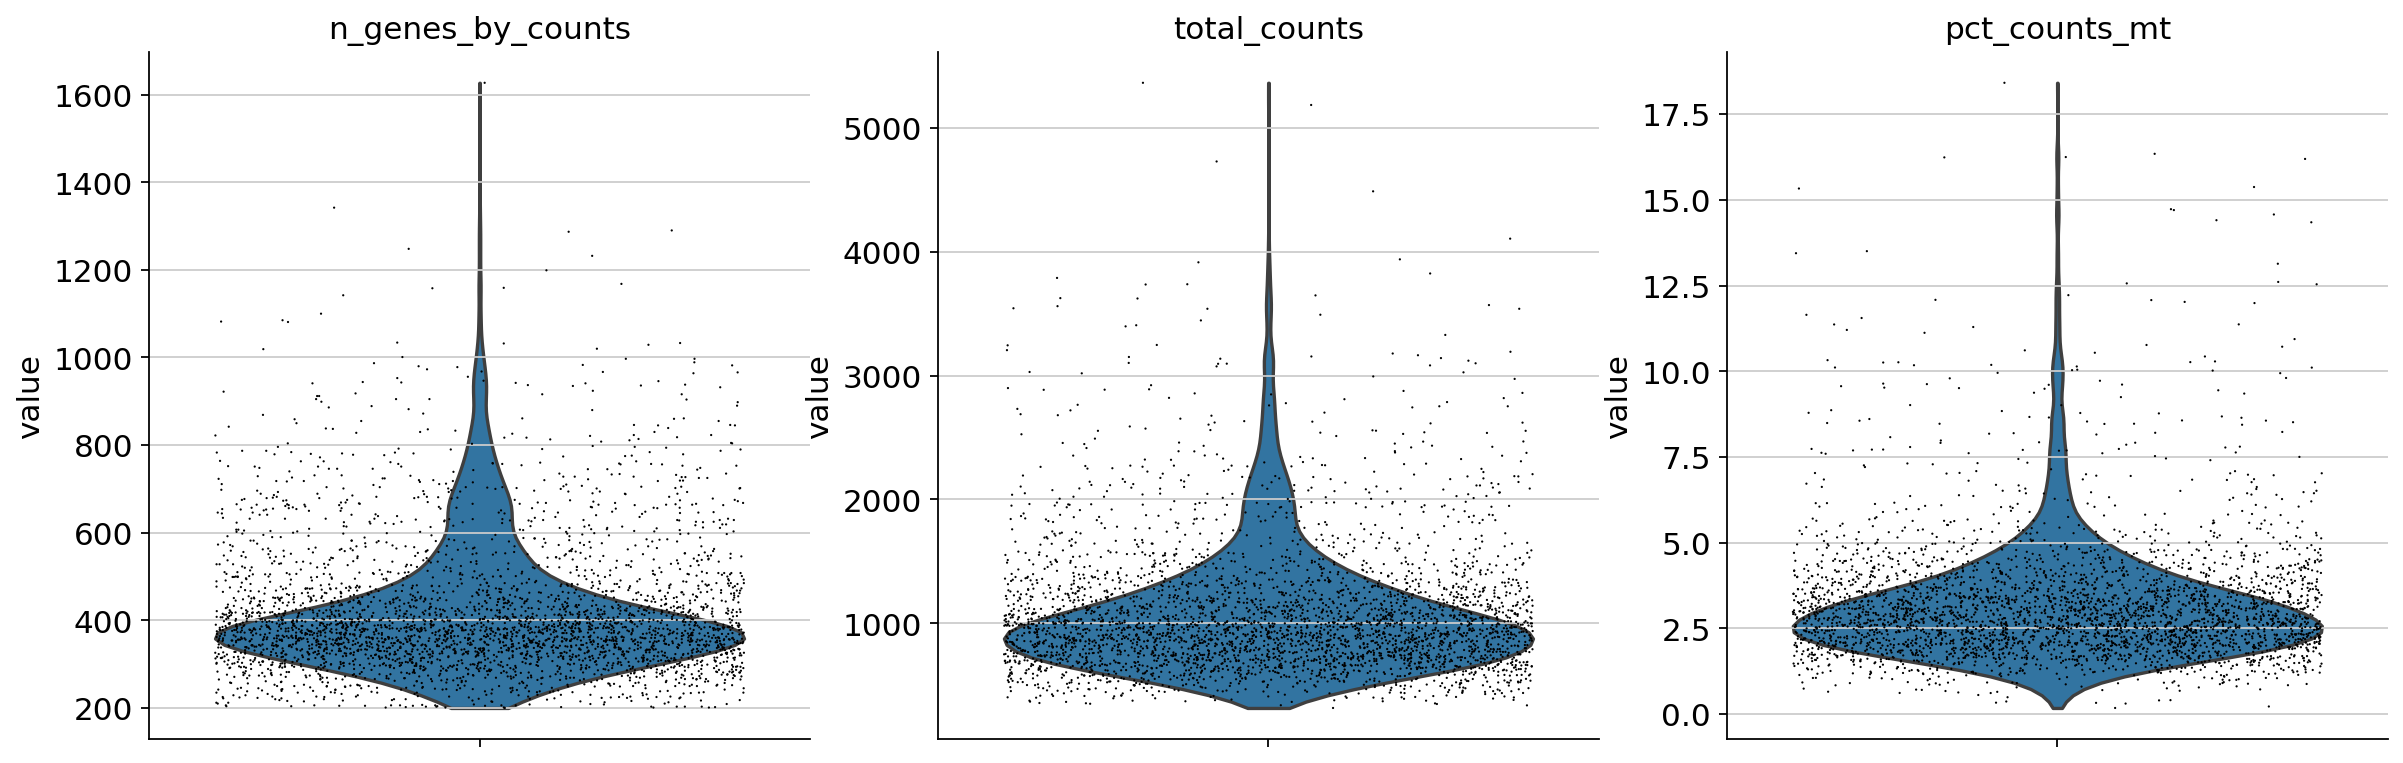

In [31]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

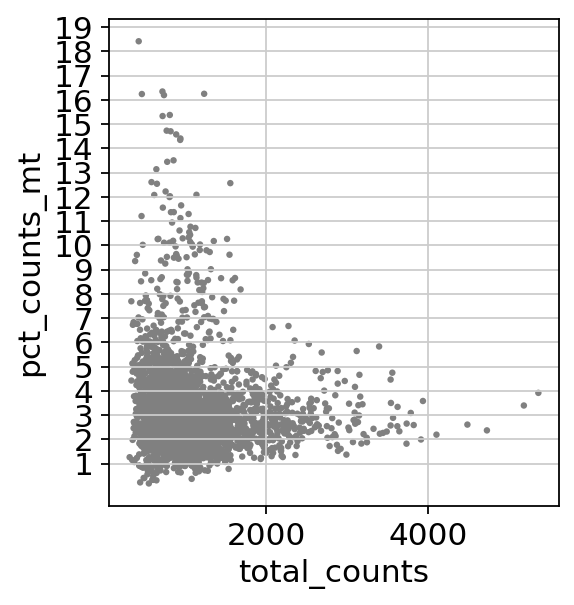

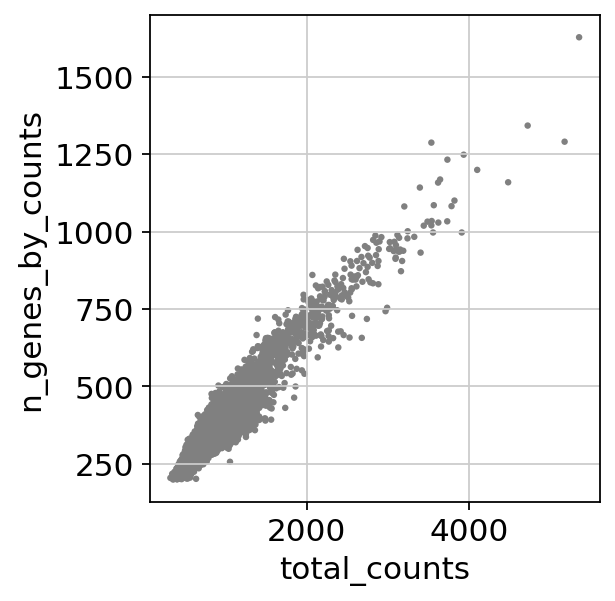

In [32]:
ax=sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',show=False)
ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [33]:
adata.obs['remove']='no'

In [34]:
#adding top 1% of cells in n_genes_by_counts to remove list
removes=adata.obs.nlargest((round(len(adata.obs['n_genes_by_counts'])/100)),'n_genes_by_counts').index.to_list()
adata.obs.loc[removes,'remove'] = 'yes'

In [35]:
remove_mt=[]
count=0
for cell in adata.obs.pct_counts_mt >6:
    if cell == True:
        remove_mt.append((adata.obs.pct_counts_mt >6).index[count])
    count+=1
len(remove_mt)


193

In [36]:
#adding cells with too high mitochondrial DNA percentage to remove list
adata.obs.loc[remove_mt,'remove']='yes'

In [37]:
# adata.obs['remove'].value_counts()

In [38]:
remove_ls = adata.obs['remove'].to_list()

In [39]:
demuxlet_souporcell_assign_ls = adata.obs['demuxlet_souporcell_assignment'].to_list()

In [40]:
remove_assign=[]
for r in range(len(demuxlet_souporcell_assign_ls)):
    if demuxlet_souporcell_assign_ls[r] == 'SNG' and remove_ls[r] == 'yes':
        remove_assign.append('SNG_remove')
    elif demuxlet_souporcell_assign_ls[r] == 'DBL' and remove_ls[r] == 'yes':
        remove_assign.append('DBL_remove')
    elif demuxlet_souporcell_assign_ls[r] == 'demuxlet_DBL' and remove_ls[r] == 'yes':
        remove_assign.append('demuxlet_DBL_remove')
    elif demuxlet_souporcell_assign_ls[r] == 'souporcell_DBL' and remove_ls[r] == 'yes':
        remove_assign.append('souporcell_DBL_remove')
    elif demuxlet_souporcell_assign_ls[r] == 'SNG' and remove_ls[r] == 'no':
        remove_assign.append('SNG_keep')
    elif demuxlet_souporcell_assign_ls[r] == 'DBL' and remove_ls[r] == 'no':
        remove_assign.append('DBL_keep')
    elif demuxlet_souporcell_assign_ls[r] == 'demuxlet_DBL' and remove_ls[r] == 'no':
        remove_assign.append('demuxlet_DBL_keep')
    elif demuxlet_souporcell_assign_ls[r] == 'souporcell_DBL' and remove_ls[r] == 'no':
        remove_assign.append('souporcell_DBL_keep')

In [41]:
#annotating what is being removed
adata.obs['remove_assignment']=remove_assign

In [42]:
filter_remove_dict=adata.obs['remove_assignment'].value_counts().to_dict()
filter_remove=pd.DataFrame([filter_remove_dict])
filter_remove.index=['filter_removals']
filter_remove=filter_remove.T
filter_remove.head(10)

filter_removals
SNG_keep                          3129
SNG_remove                         212
DBL_keep                            94
demuxlet_DBL_keep                   86
DBL_remove                           8
demuxlet_DBL_remove                  7
souporcell_DBL_keep                  5
souporcell_DBL_remove                1

In [43]:
# adata.obs['remove_assignment'].value_counts(normalize=True) * 100


In [44]:
# adata.obs['demuxlet_assignment_simple'].value_counts(normalize=True) * 100

In [45]:
# adata.obs['souporcell_assignment_simple'].value_counts(normalize=True) * 100

In [46]:
# adata.obs['demuxlet_souporcell_assignment'].value_counts(normalize=True) * 100

In [47]:
# adata.obs['demuxlet_assignment_simple'].value_counts()

In [48]:
# adata.obs['souporcell_assignment_simple'].value_counts()

In [49]:
# adata.obs['demuxlet_souporcell_assignment'].value_counts()

In [50]:
#removing cell that are marked to be removed
adata= adata[adata.obs.remove.str.startswith('no'), :]

In [51]:
demuxlet_assignment_percent=(adata.obs['demuxlet_assignment_simple'].value_counts(normalize=True) * 100).to_dict()
demuxlet_assignment_percent['SNG_percentage'] = demuxlet_assignment_percent.pop('SNG')
demuxlet_assignment_percent['DBL_percentage'] = demuxlet_assignment_percent.pop('DBL')


In [52]:
souporcell_assignment_percent=(adata.obs['souporcell_assignment_simple'].value_counts(normalize=True) * 100).to_dict()
souporcell_assignment_percent['SNG_percentage'] = souporcell_assignment_percent.pop('SNG')
souporcell_assignment_percent['DBL_percentage'] = souporcell_assignment_percent.pop('DBL')

In [53]:
demux_assign_dict=adata.obs['demuxlet_assignment_simple'].value_counts().to_dict()
soupor_assign_dict=adata.obs['souporcell_assignment_simple'].value_counts().to_dict()
assignments=pd.DataFrame([demux_assign_dict,soupor_assign_dict,])
assignments['total']=sum(demux_assign_dict.values())
assignments['SNG_percentage']=demuxlet_assignment_percent['SNG_percentage']
assignments['DBL_percentage']=demuxlet_assignment_percent['DBL_percentage']
assignments.at[1,'SNG_percentage']=souporcell_assignment_percent['SNG_percentage']
assignments.at[1,'DBL_percentage']=souporcell_assignment_percent['DBL_percentage']

assignments.index=['demuxlet_assignment','souporcell_assignment']
assignments.head()

SNG  DBL  total  SNG_percentage  DBL_percentage
demuxlet_assignment    3134  180   3314       94.568497        5.431503
souporcell_assignment  3215   99   3314       97.012674        2.987326

In [54]:
demux_soupor_dict=adata.obs['demuxlet_souporcell_assignment'].value_counts().to_dict()

In [55]:
demux_soupor=pd.DataFrame([demux_soupor_dict])
demux_soupor.index=['demuxlet_souporcell_assignment']
demux_soupor=demux_soupor.T
demux_soupor.head()

demuxlet_souporcell_assignment
SNG                                       3129
DBL                                         94
demuxlet_DBL                                86
souporcell_DBL                               5

In [56]:
#normalizing data
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/akivakohane/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [57]:
#log of data
sc.pp.log1p(adata)

In [58]:
#getting highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [59]:
sc.pl.highly_variable_genes(adata)

In [60]:
adata.raw = adata

In [61]:
adata = adata[:, adata.var.highly_variable]

In [62]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/home/akivakohane/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/akivakohane/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'remove' as categorical
/home/akivakohane/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
.

    finished (0:00:13)


In [63]:
#scaling data
sc.pp.scale(adata,max_value=7)

In [64]:
#calculating PCA
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [65]:
sc.pl.pca(adata, color=['demuxlet_souporcell_assignment'], ncols=10)

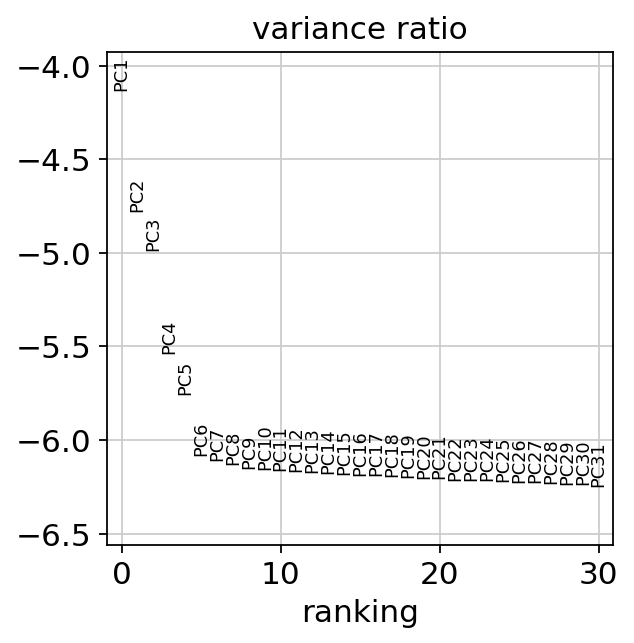

In [66]:
sc.pl.pca_variance_ratio(adata, log=True)


In [67]:
adata.write(results_file)

In [68]:
adata

AnnData object with n_obs × n_vars = 3314 × 1718
    obs: 'demuxlet_assignment', 'demuxlet_DBL_llk', 'demuxlet_assignment_2', 'demuxlet_DBL_llk_2', 'souporcell_assignment', 'souporcell_doublet_logprob', 'demuxlet_assignment_simple_2', 'demuxlet_assignment_simple', 'souporcell_assignment_simple', 'demuxlet_souporcell_assignment', 'sample_assignment_s', 'sample_assignment_d', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'remove', 'remove_assignment'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'demuxlet_souporcell_assignment_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [69]:
#creating neighbothood
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [70]:
#calculating UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [71]:
#reordering categories of assingment annotations
adata.obs['demuxlet_souporcell_assignment'].cat.reorder_categories(['DBL','souporcell_DBL','demuxlet_DBL','SNG'], inplace=True)
adata.obs['demuxlet_assignment_simple_2'].cat.reorder_categories(['SNG','DBL'], inplace=True)

/home/akivakohane/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/home/akivakohane/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


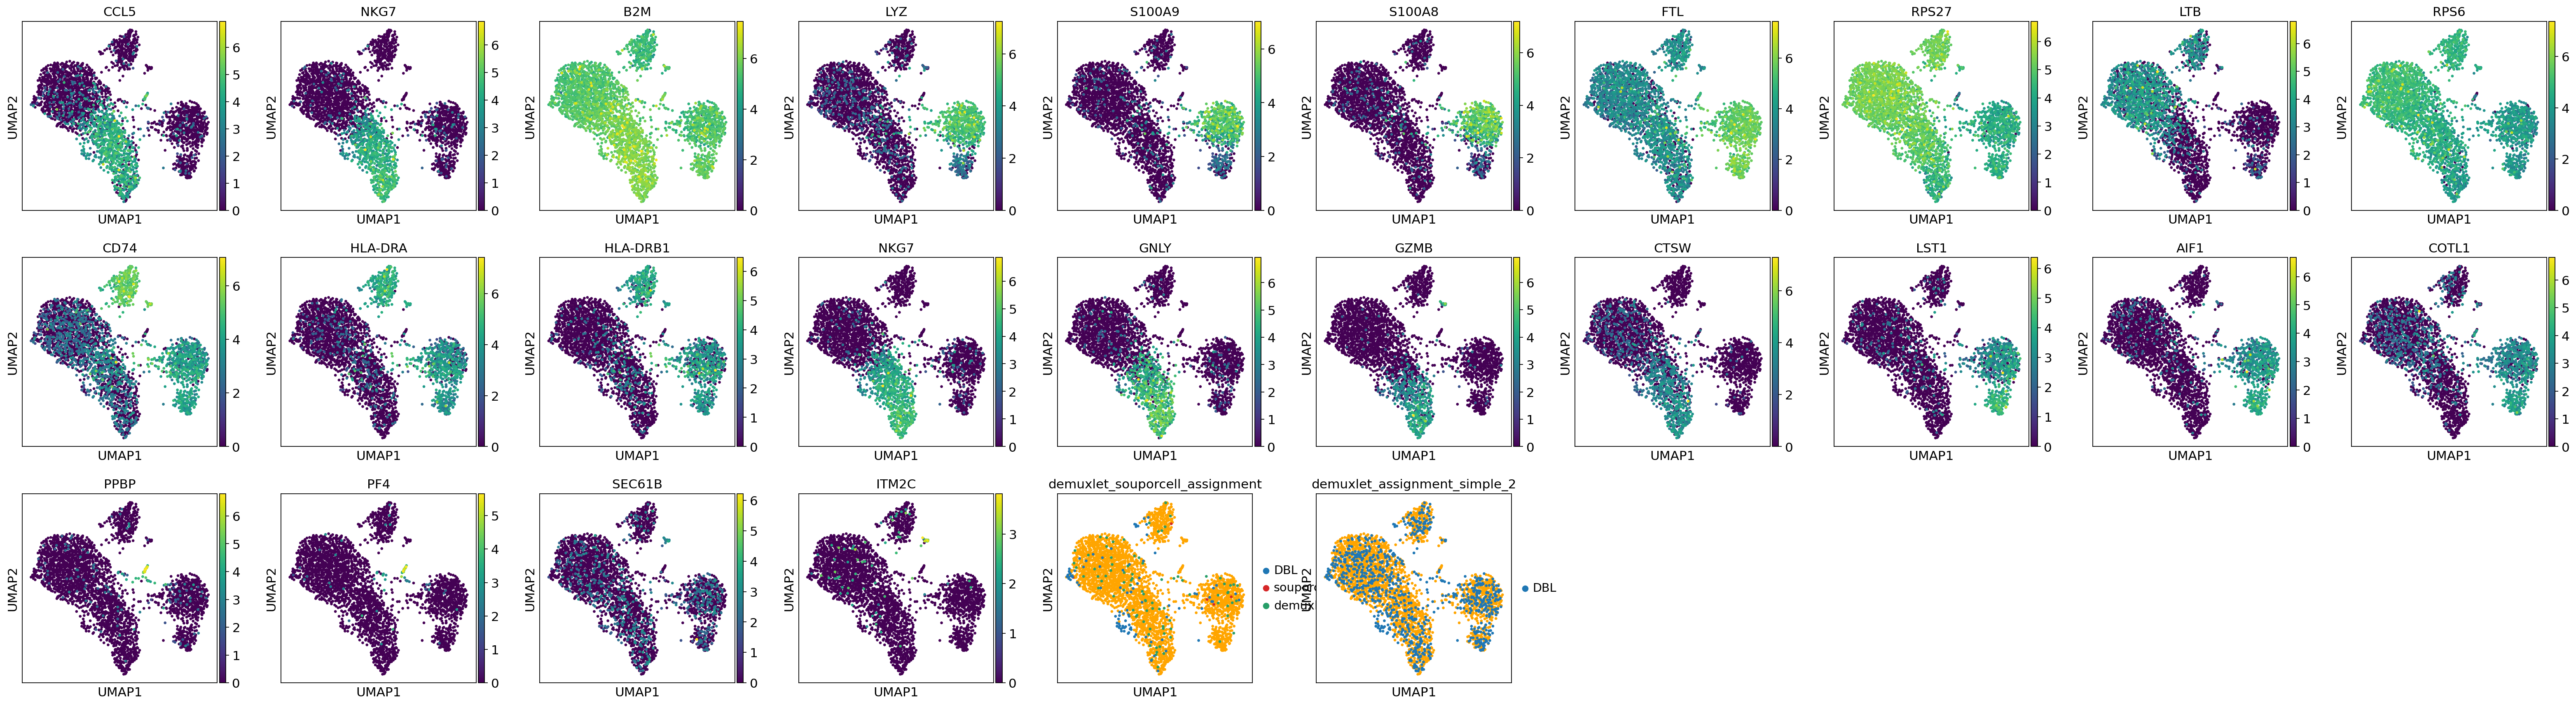

In [72]:
#UMAP plot with with expression of different genes
sc.pl.umap(adata, color=[ 'CCL5','NKG7','B2M','LYZ','S100A9','S100A8','FTL','RPS27','LTB','RPS6','CD74','HLA-DRA','HLA-DRB1','NKG7',
             'GNLY','GZMB','CTSW','LST1','AIF1','COTL1','PPBP','PF4','SEC61B','ITM2C', 'demuxlet_souporcell_assignment', 'demuxlet_assignment_simple_2'],sort_order=True,groups=['demuxlet_DBL','souporcell_DBL','DBL'
],na_color='orange',na_in_legend=False, ncols=10)

In [73]:
#calculating clustering of cells with leiden
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


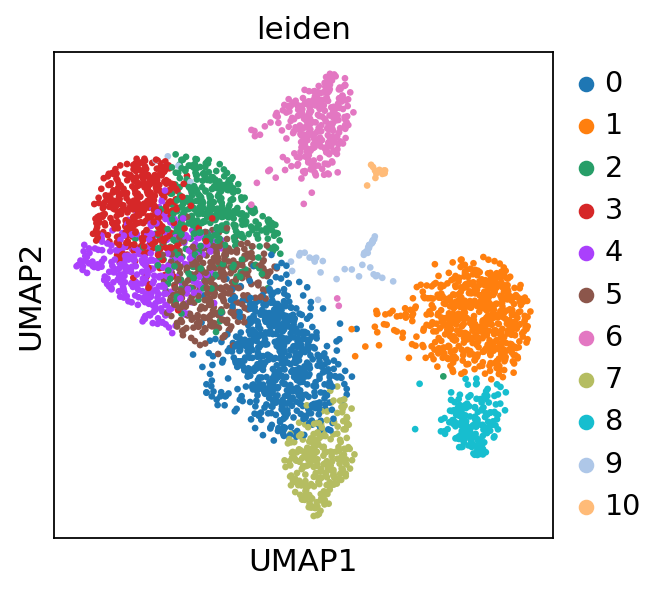

In [74]:
#UMAP plot with leiden clustering
sc.pl.umap(adata, color=['leiden'])

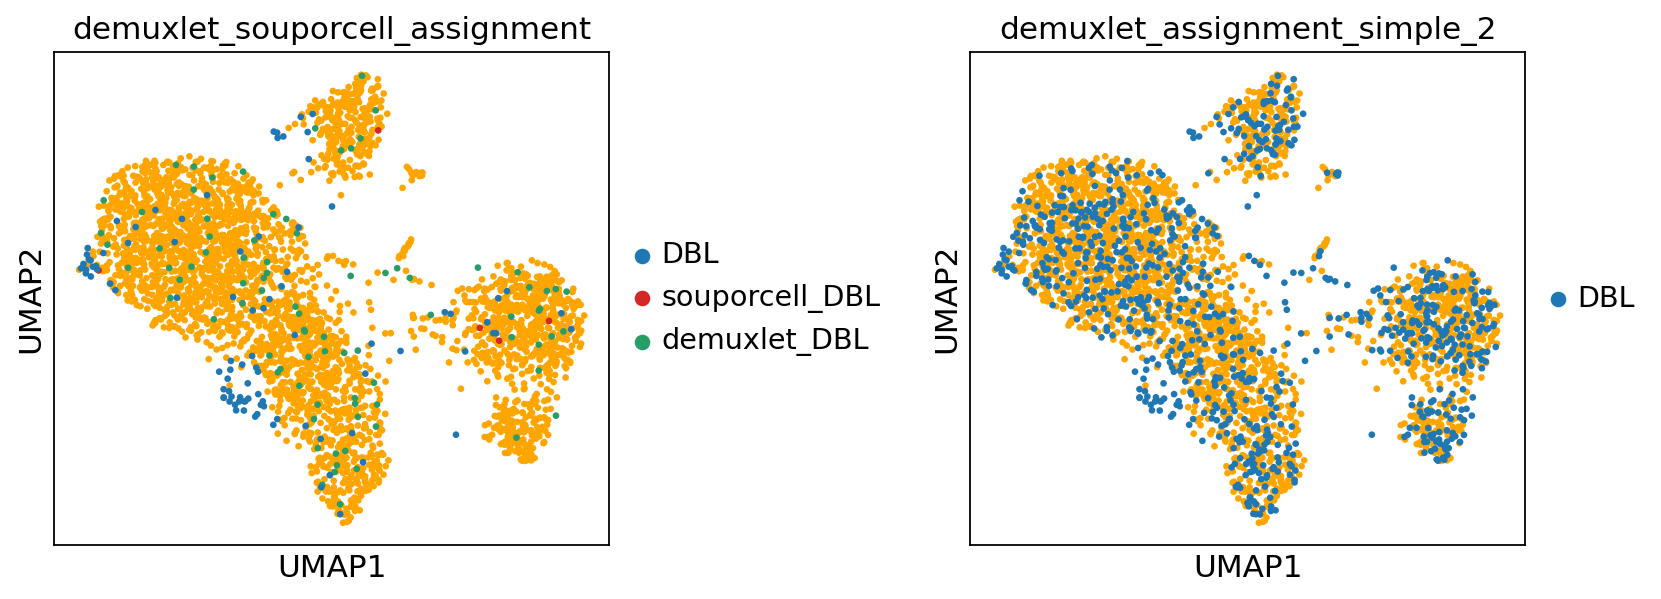

In [75]:
#UMAP with demuxlet_souporcell_assignment and UMAP with demuxlet without alpaha parameter doublets 
ax=sc.pl.umap(adata, color=['demuxlet_souporcell_assignment', 'demuxlet_assignment_simple_2'],sort_order=True,groups=['demuxlet_DBL','souporcell_DBL','DBL'
],na_color='orange',na_in_legend=False, wspace=.5)



In [76]:
#getting UMAP coordinates of cells
umap_coords=pd.DataFrame(adata.obsm['X_umap'])
umap_coords.index=adata.obs.index.to_list()
ds_assign=adata.obs['demuxlet_souporcell_assignment']
umap_coords=umap_coords.join(ds_assign)
d2_assign=adata.obs['demuxlet_assignment_simple_2']
umap_coords=umap_coords.join(d2_assign)
leiden=adata.obs['leiden']
umap_coords=umap_coords.join(leiden)
indexNames = umap_coords[umap_coords['demuxlet_souporcell_assignment'] == 'SNG'].index
umap_coords.drop(indexNames , inplace=True)
umap_coords.head()

0         1 demuxlet_souporcell_assignment  \
AAACGGCTGACAGG-1  4.572000  8.637394                   demuxlet_DBL   
AAATGTTGCTGTCC-1  1.687275  1.656677                            DBL   
AACCGATGTGACAC-1  2.422288  1.613352                   demuxlet_DBL   
AACGGTACGGATCT-1 -0.211086  8.057441                   demuxlet_DBL   
AAGACAGAGAAGGC-1 -3.571721  4.956708                            DBL   

                 demuxlet_assignment_simple_2 leiden  
AAACGGCTGACAGG-1                          DBL      6  
AAATGTTGCTGTCC-1                          DBL      0  
AACCGATGTGACAC-1                          DBL      0  
AACGGTACGGATCT-1                          DBL      2  
AAGACAGAGAAGGC-1                          DBL      4

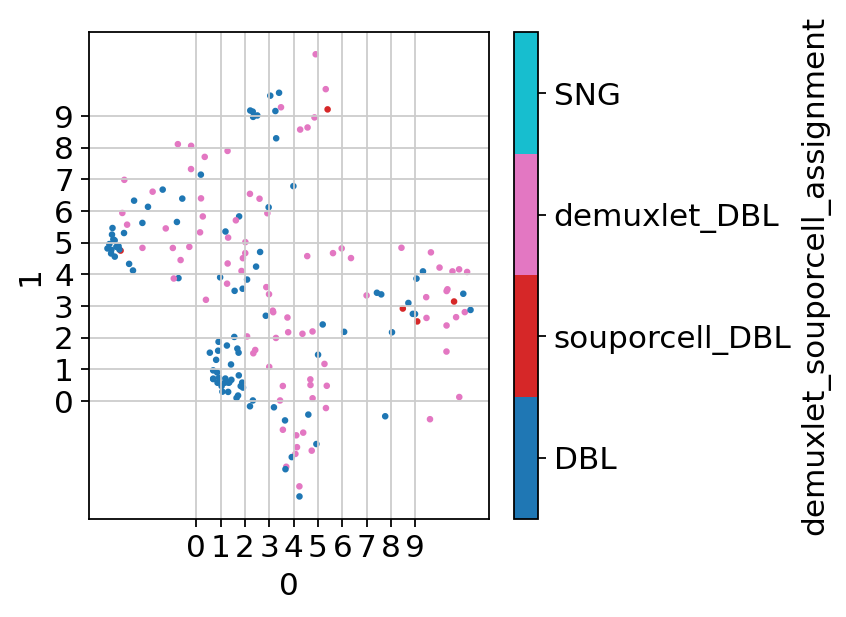

In [77]:
#replotting UMAP coordinates with matplotlib to display coordinates
coords=umap_coords.plot.scatter(0,1,15,marker=".",c='demuxlet_souporcell_assignment',colormap='tab10')
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

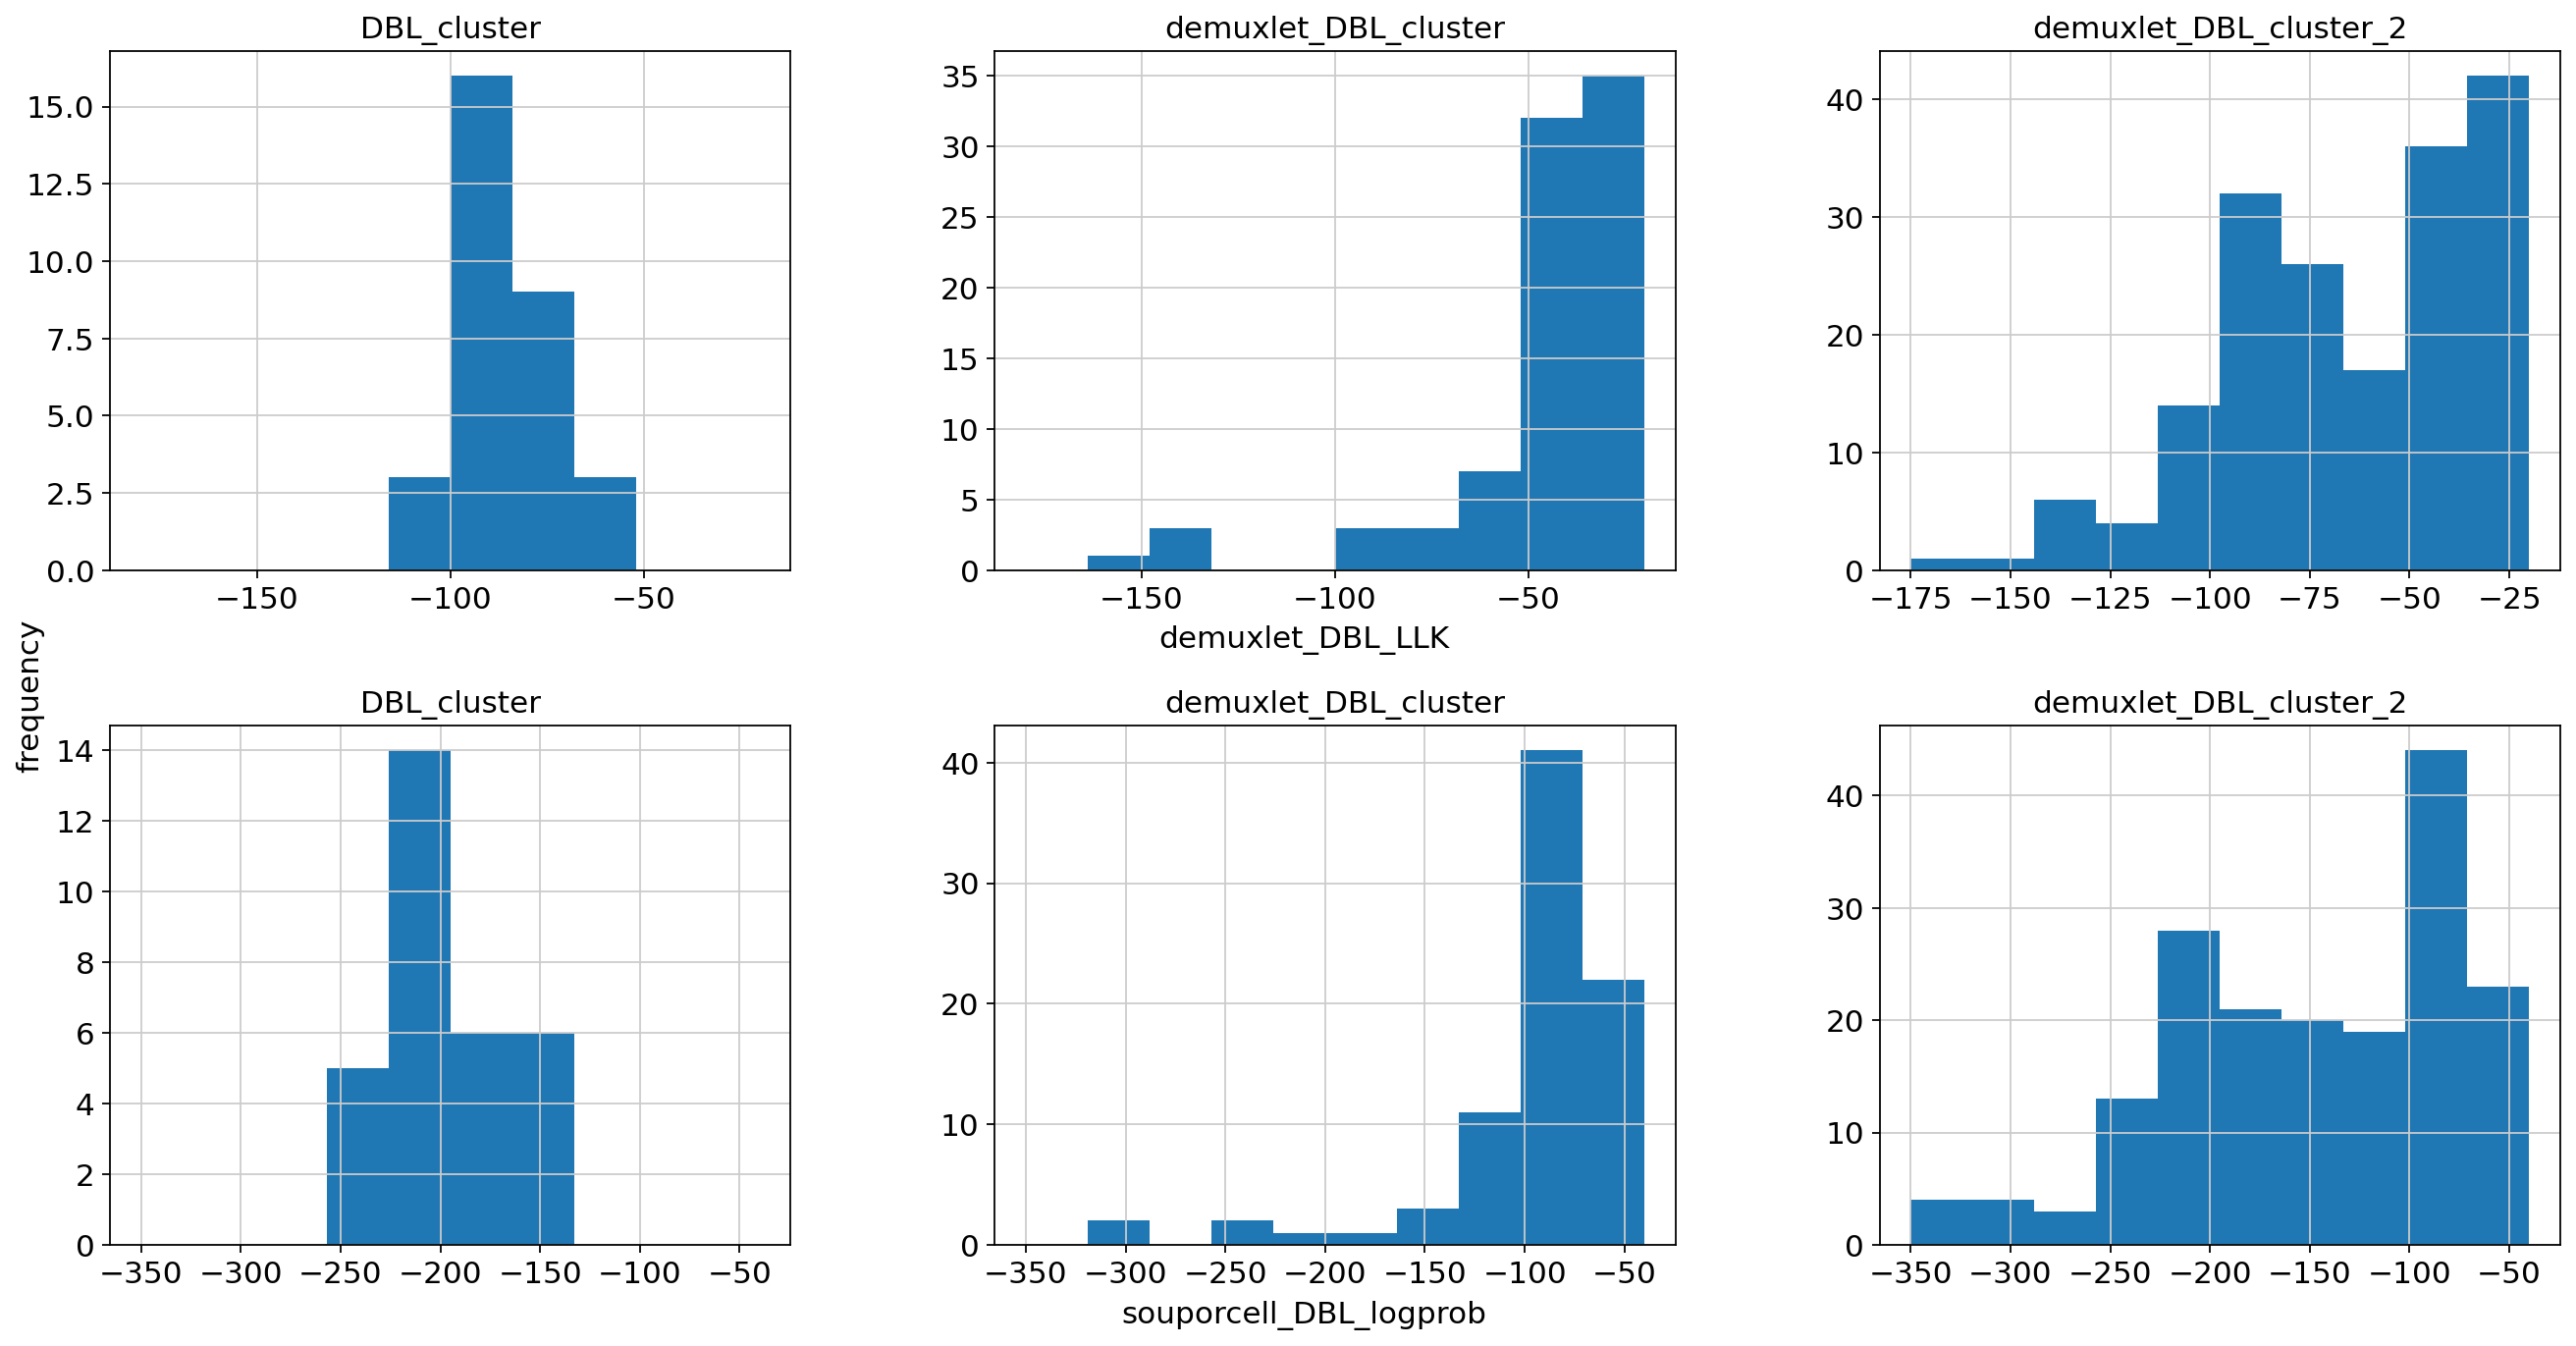

In [78]:
#Creating histograms of different doublet clusters with demuxlet log liklihood and souporcell doublet log probabilty
#DBL_cluster is cluster of DBL between 0 and 3 on 0 axis and below 2 on 1 axis
#demuxlet_DBL_cluster is cluster of demuxlet_DBL less than 6 on 0 axis and below 8 on 1 axis
#demuxlet_DBL_cluster_2 is the cluster in the same area as demuxlet_DBL_cluster except there are the doublets
#from the demuxlet run without the alpha parameter
DBL_cluster = umap_coords[(umap_coords['demuxlet_souporcell_assignment']=='DBL')&(umap_coords[0] <3) & (umap_coords[1]<2.2)].index.to_list()
DBL_hist=adata.obs.loc[DBL_cluster]['demuxlet_DBL_llk'].to_list()

demuxlet_DBL_cluster = umap_coords[(umap_coords['demuxlet_souporcell_assignment']=='demuxlet_DBL')&(umap_coords['leiden']!=10)&(umap_coords['leiden']!=9)
                                   &(umap_coords['leiden']!=8)&(umap_coords['leiden']!=6)&(umap_coords['leiden']!=1)].index.to_list()
demuxlet_DBL_cluster_hist=adata.obs.loc[demuxlet_DBL_cluster]['demuxlet_DBL_llk'].to_list()

demuxlet_DBL_cluster_2 = umap_coords[(umap_coords['demuxlet_assignment_simple_2']=='DBL')&(umap_coords['leiden']!=10)&(umap_coords['leiden']!=9)
                                   &(umap_coords['leiden']!=8)&(umap_coords['leiden']!=6)&(umap_coords['leiden']!=1)].index.to_list()
demuxlet_DBL_cluster_hist_2=adata.obs.loc[demuxlet_DBL_cluster_2]['demuxlet_DBL_llk_2'].to_list()

DBL_hist_s=adata.obs.loc[DBL_cluster]['souporcell_doublet_logprob'].to_list()

demuxlet_DBL_cluster_hist_s=adata.obs.loc[demuxlet_DBL_cluster]['souporcell_doublet_logprob'].to_list()

demuxlet_DBL_cluster_hist_2_s=adata.obs.loc[demuxlet_DBL_cluster_2]['souporcell_doublet_logprob'].to_list()


df1 = pd.DataFrame(dict(DBL_cluster=DBL_hist))
df2 = pd.DataFrame(dict(demuxlet_DBL_cluster=demuxlet_DBL_cluster_hist))
df3 = pd.DataFrame(dict(demuxlet_DBL_cluster_2=demuxlet_DBL_cluster_hist_2))
df4 = pd.DataFrame(dict(DBL_cluster=DBL_hist_s))
df5 = pd.DataFrame(dict(demuxlet_DBL_cluster=demuxlet_DBL_cluster_hist_s))
df6 = pd.DataFrame(dict(demuxlet_DBL_cluster_2=demuxlet_DBL_cluster_hist_2_s))

fig, axes = plt.subplots(2,3,figsize=(20,10))

df1.hist('DBL_cluster', ax=axes[0][0], range=[-180, -20])
df2.hist('demuxlet_DBL_cluster', ax=axes[0][1], range=[-180, -20])
df3.hist('demuxlet_DBL_cluster_2', ax=axes[0][2], range=[-175, -20])
df4.hist('DBL_cluster', ax=axes[1][0], range=[-350, -40])
df5.hist('demuxlet_DBL_cluster', ax=axes[1][1], range=[-350, -40])
df6.hist('demuxlet_DBL_cluster_2', ax=axes[1][2], range=[-350, -40])
fig.text(.15, 0.5, 'frequency', va='center', rotation='vertical')
fig.text(0.56, 0.53, 'demuxlet_DBL_LLK', ha='center')
fig.text(0.56, 0.1, 'souporcell_DBL_logprob', ha='center')


plt.show()



In [79]:
adata.write(results_file)

In [80]:
#creating ranking of genes from each leiden cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [81]:
sc.settings.verbosity = 2  

ranking genes
    finished (0:00:03)


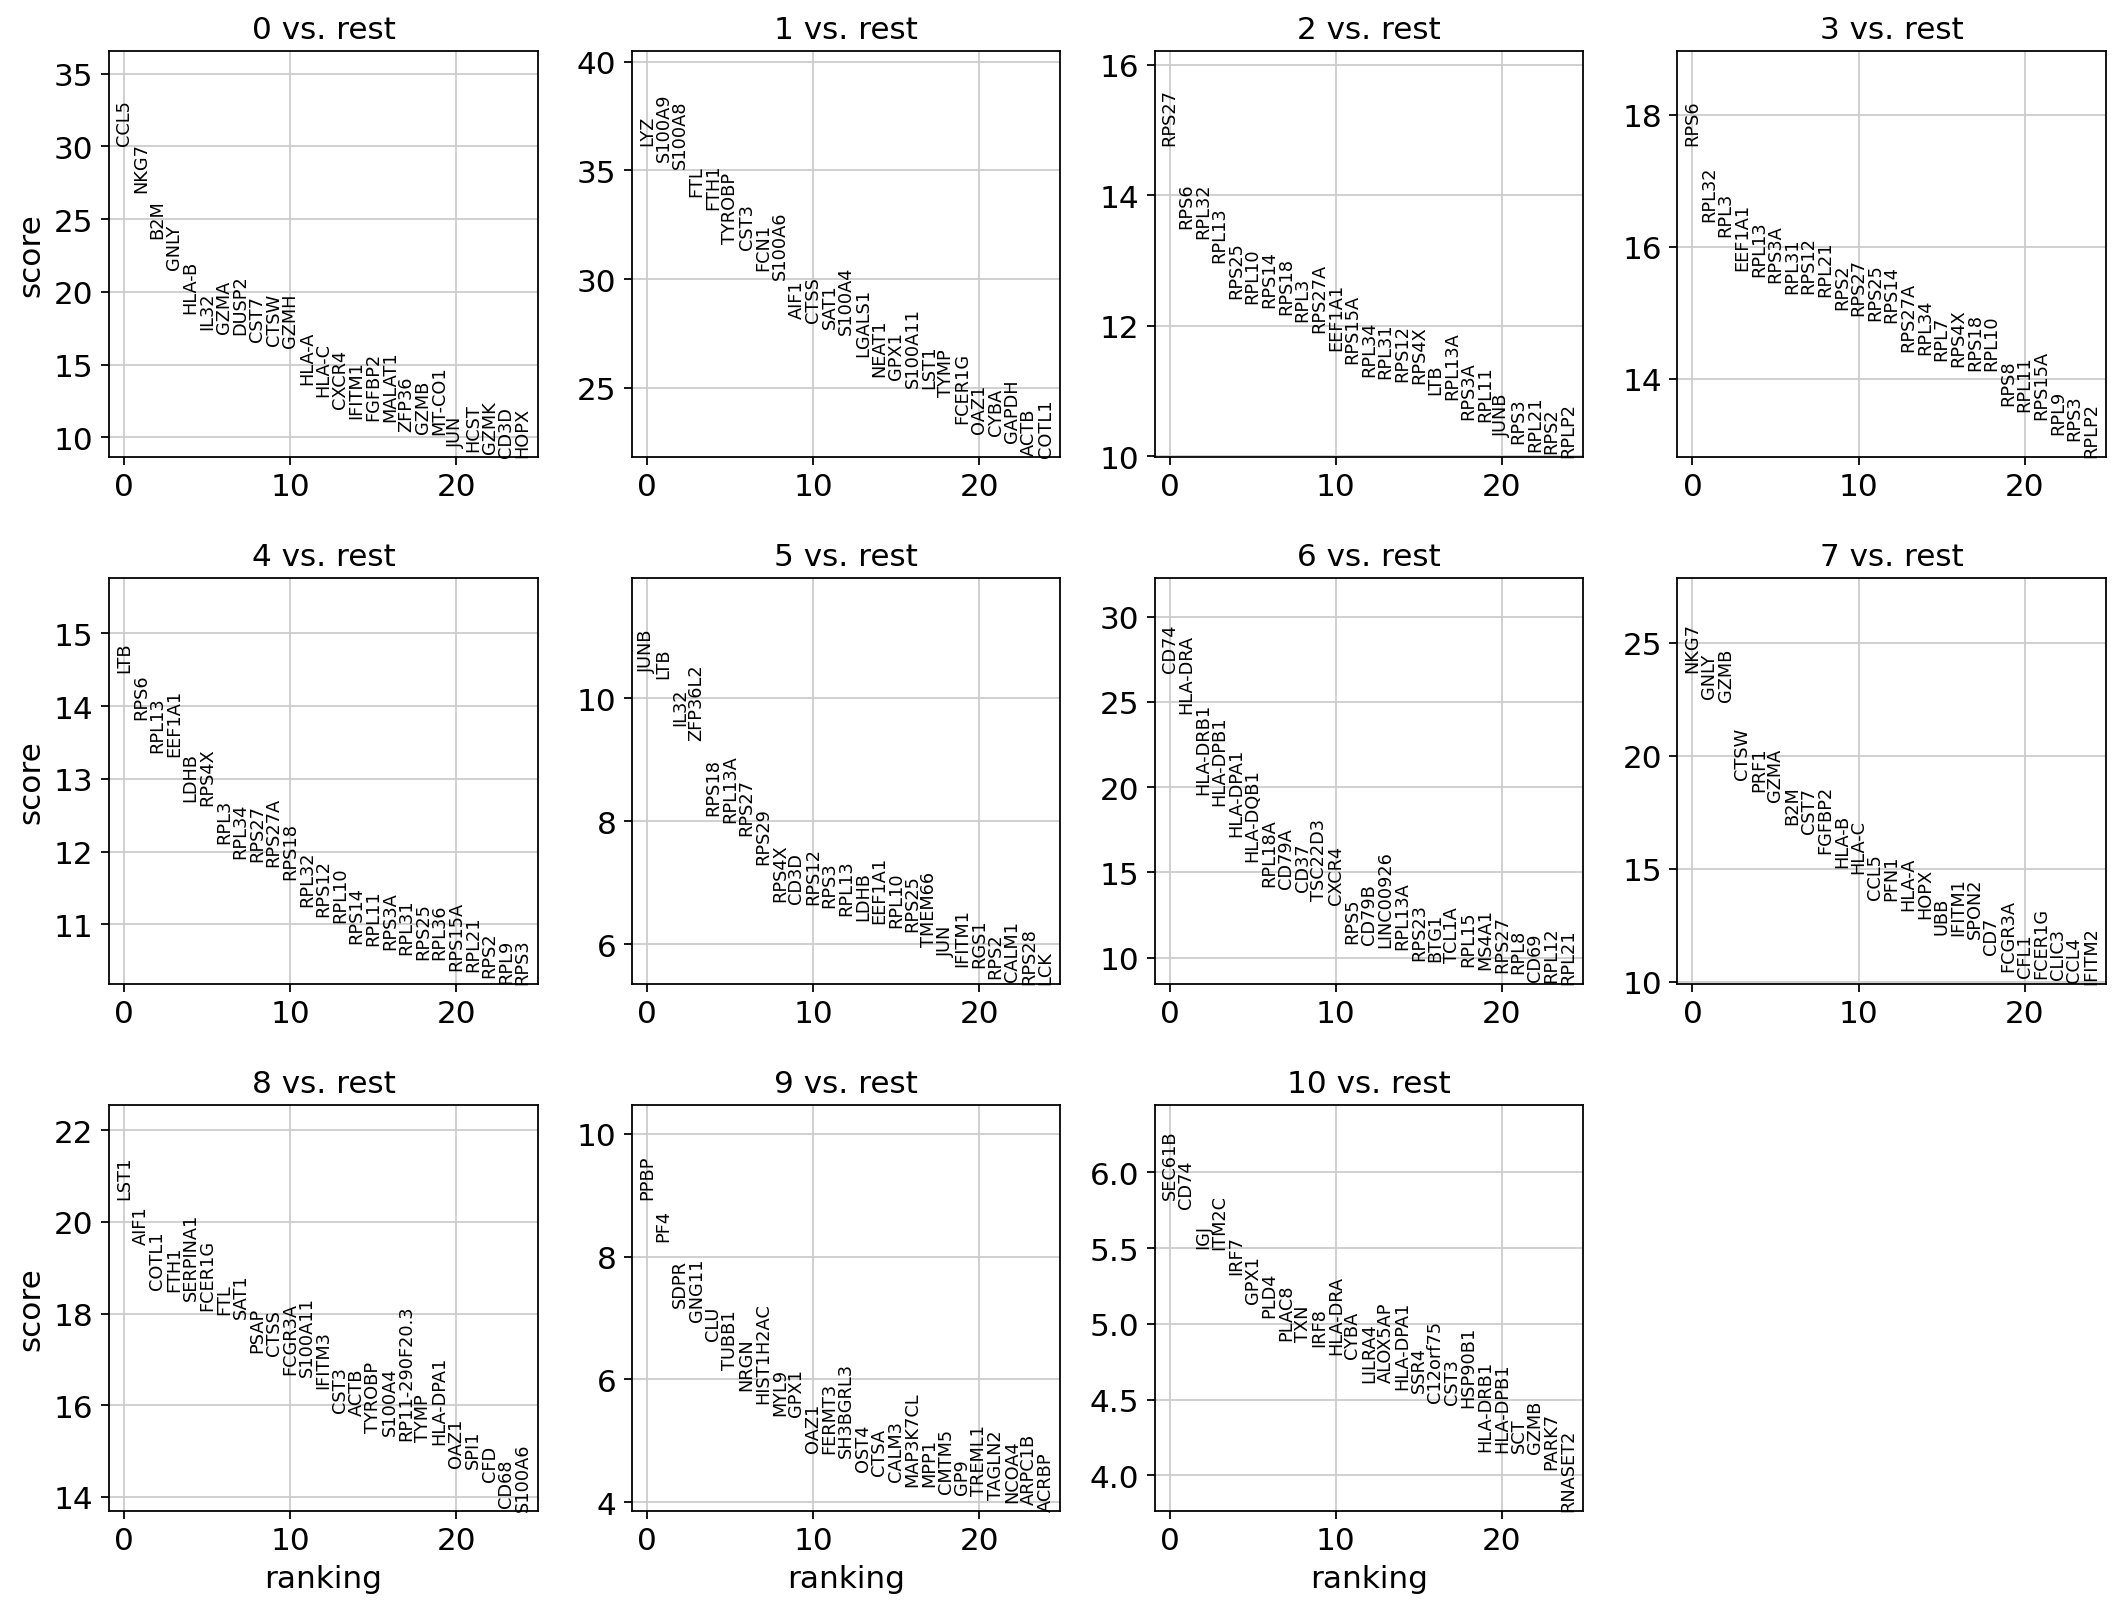

In [82]:
#creating ranking of genes from each leiden cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [83]:
adata.write(results_file)

In [84]:
#creating ranking of genes from each leiden cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished (0:00:16)


/home/akivakohane/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [85]:
marker_genes=['CCL5','NKG7','B2M','LYZ','S100A9','S100A8','FTL','RPS27','LTB','RPS6','CD74','HLA-DRA','HLA-DRB1','NKG7',
             'GNLY','GZMB','CTSW','LST1','AIF1','COTL1','PPBP','PF4','SEC61B','ITM2C']

In [86]:
adata = sc.read(results_file)

In [87]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1      2       3       4        5         6     7         8  \
0   CCL5     LYZ  RPS27    RPS6     LTB     JUNB      CD74  NKG7      LST1   
1   NKG7  S100A9   RPS6   RPL32    RPS6      LTB   HLA-DRA  GNLY      AIF1   
2    B2M  S100A8  RPL32    RPL3   RPL13     IL32  HLA-DRB1  GZMB     COTL1   
3   GNLY     FTL  RPL13  EEF1A1  EEF1A1  ZFP36L2  HLA-DPB1  CTSW      FTH1   
4  HLA-B    FTH1  RPS25   RPL13    LDHB    RPS18  HLA-DPA1  PRF1  SERPINA1   

       9      10  
0   PPBP  SEC61B  
1    PF4    CD74  
2   SDPR     IGJ  
3  GNG11   ITM2C  
4    CLU    IRF7

In [88]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n            1_p    2_n           2_p     3_n  \
0   CCL5  5.331180e-199     LYZ  1.501108e-286  RPS27  2.282587e-49    RPS6   
1   NKG7  9.418409e-159  S100A9  7.483792e-275   RPS6  1.704204e-41   RPL32   
2    B2M  2.940985e-124  S100A8  2.074274e-270  RPL32  1.267206e-40    RPL3   
3   GNLY  6.769537e-103     FTL  5.106565e-251  RPL13  1.796642e-38  EEF1A1   
4  HLA-B   1.002195e-76    FTH1  3.077197e-242  RPS25  1.909130e-35   RPL13   

            3_p     4_n           4_p      5_n           5_p       6_n  \
0  6.606948e-69     LTB  1.850527e-47     JUNB  1.809503e-25      CD74   
1  2.429777e-60    RPS6  1.752106e-43      LTB  5.257519e-25   HLA-DRA   
2  1.028211e-58   RPL13  8.693462e-41     IL32  1.179294e-21  HLA-DRB1   
3  3.544098e-55  EEF1A1  1.932735e-40  ZFP36L2  1.149035e-20  HLA-DPB1   
4  1.270402e-54    LDHB  6.273098e-37    RPS18  5.177706e-16  HLA-DPA1   

             6_p   7_n            7_p       8_n           8_p    9_n  \
0  7.262102e-158  NKG7  2.737886e-124      LST1  1.854636e-93   PPBP   
1  8.177801e-131  GNLY  8.093120e-113      AIF1  8.291287e-85    PF4   
2   1.108032e-85  GZMB  2.798448e-111     COTL1  1.047835e-76   SDPR   
3   4.921223e-80  CTSW   3.605772e-80      FTH1  2.715823e-76  GNG11   
4   4.670465e-66  PRF1   4.686618e-76  SERPINA1  1.028906e-74    CLU   

            9_p    10_n          10_p  
0  3.807826e-19  SEC61B  5.666511e-09  
1  1.615170e-16    CD74  8.226413e-09  
2  6.619315e-13     IGJ  3.832705e-08  
3  3.699756e-12   ITM2C  3.863237e-08  
4  3.007683e-11    IRF7  9.804946e-08

ranking genes
    finished (0:00:00)


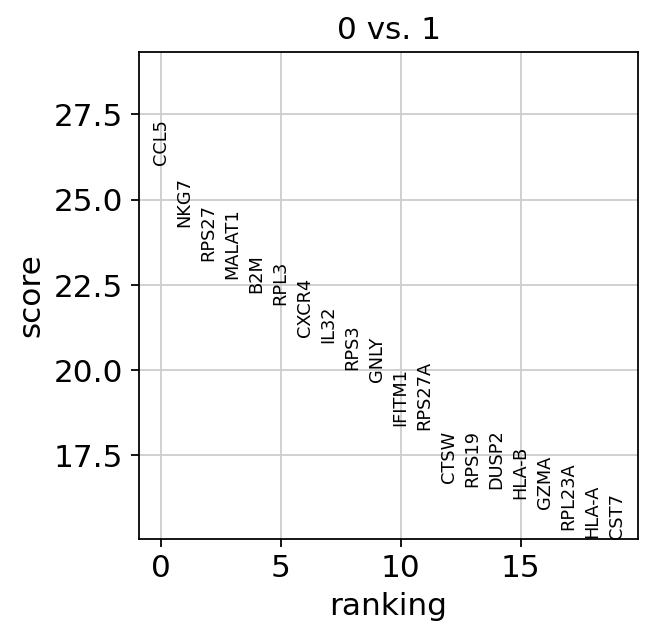

In [89]:
#rank of cluster 0 marker genes vs rank of same genes in cluster 1
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [90]:
#expression of cluster 0 marker genes vs expression of same genes in cluster 1
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [91]:
adata = sc.read(results_file)

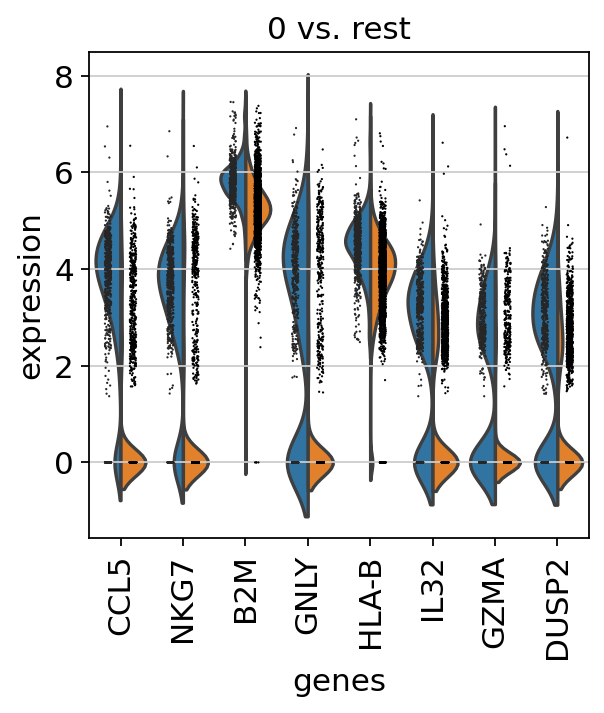

In [92]:
#expression of cluster 0 marker genes vs expression of same genes in rest of clusters

sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

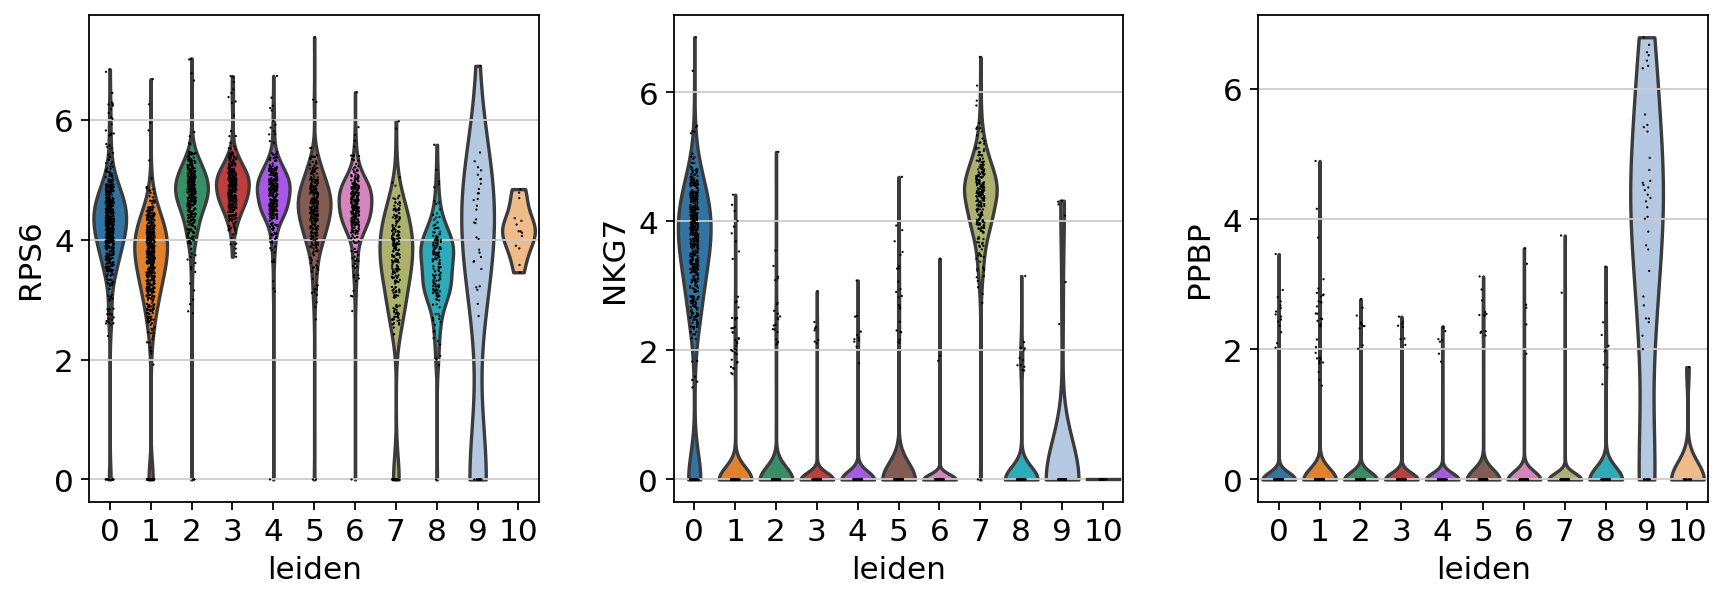

In [93]:
#certain marker genes expression by leiden cluster
sc.pl.violin(adata, ['RPS6', 'NKG7', 'PPBP'], groupby='leiden')

In [94]:
#assigning cell types using https://docs.dseqr.com and giving same files given to anndata in this notebook
new_cluster_names = ['CD8 TEM','CD14 Mono','CD4 TCM2','CD4 TCM3','CD4 TCM4','CD4 TCM5','B naive','NK','CD16 Mono','Platelet','pDC']
adata.rename_categories('leiden', new_cluster_names)

/home/akivakohane/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [95]:
leiden_ls=adata.obs['leiden'].to_list()

In [96]:
adata.obs['cell_type'] = leiden_ls

In [97]:
#cell types mapped on UMAP
sc.pl.umap(adata, color= 'cell_type', title='', frameon=False, save='.pdf')

/home/akivakohane/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


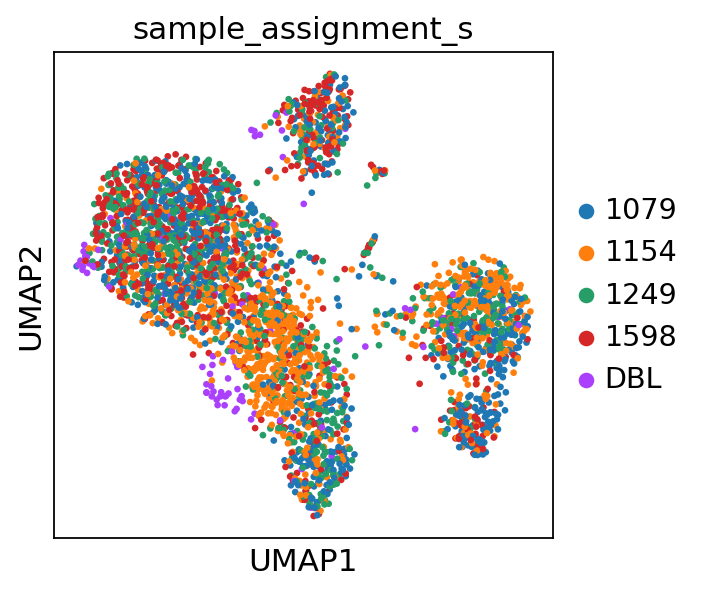

In [98]:
#samples mapped on UMAP
sc.pl.umap(adata, color= 'sample_assignment_s')

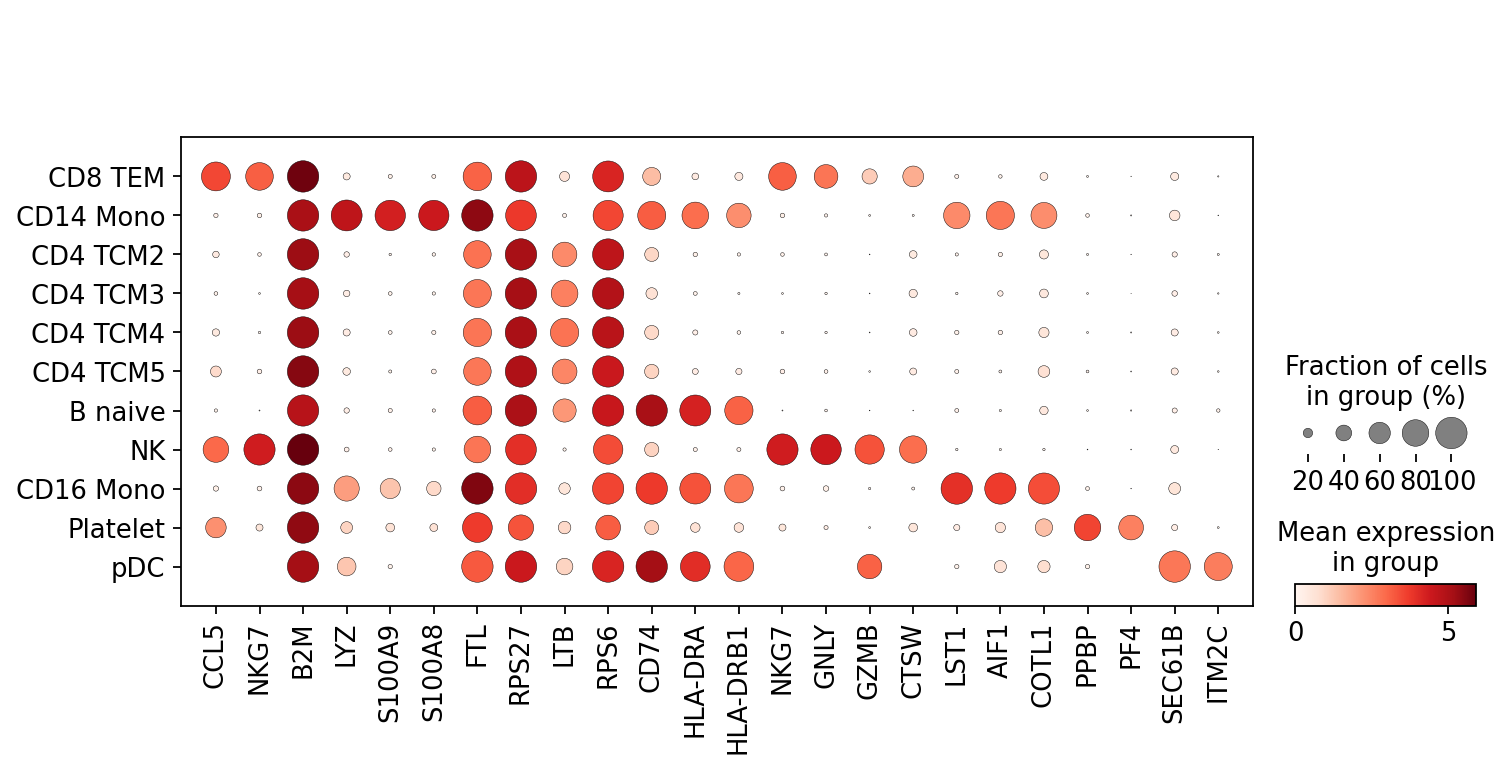

In [99]:
#marker genes expression in each cell type
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

In [100]:
sample_assign_s2 = adata.obs['sample_assignment_s'].to_list()

In [101]:
#count of cell type in samples
s1154 = []
s1079 = []
s1249 = []
s1598 = []
DBL= []
count=0
for t in sample_assign_s2:
    if sample_assign_s2[count] == '1154':
        s1154.append(leiden_ls[count])
    elif sample_assign_s2[count] == '1079':
        s1079.append(leiden_ls[count])
    elif sample_assign_s2[count] == '1249':
        s1249.append(leiden_ls[count])
    elif sample_assign_s2[count] == '1598':
        s1598.append(leiden_ls[count])
    else:
        DBL.append(leiden_ls[count])
    count+=1

In [102]:
samples=[s1154,s1079,s1249,s1598,DBL]
samples_df=pd.DataFrame(samples)
samples_df=samples_df.T
samples_df.columns=['1154','1079','1249','1598','DBL']

In [103]:
# samples_df['1154'].value_counts(normalize=True) * 100

In [104]:
# samples_df['1079'].value_counts(normalize=True) * 100

In [105]:
# samples_df['1249'].value_counts(normalize=True) * 100


In [106]:
# samples_df['1598'].value_counts(normalize=True) * 100

In [107]:
# samples_df['DBL'].value_counts(normalize=True) * 100

In [108]:
#count of samples in each cell type
CD8_TEM=[]
CD14_Mono=[]
CD4_TCM2=[]
CD4_TCM3=[]
CD4_TCM4=[]
CD4_TCM5=[]
B_naive=[]
NK=[]
CD16_Mono=[]
Platelet=[]
pDC=[]
cell_type_ls=[CD8_TEM,CD14_Mono,CD4_TCM2,CD4_TCM3,CD4_TCM4,CD4_TCM5,B_naive,NK,CD16_Mono,Platelet,pDC]
count=0
for cell in new_cluster_names:
    count2=0
    for t in leiden_ls:
        if leiden_ls[count2] == cell:
            cell_type_ls[count].append(sample_assign_s2[count2])
        count2+=1
    count+=1


In [109]:
cell_type_df=pd.DataFrame(cell_type_ls)
cell_type_df=cell_type_df.T
cell_type_df.columns=new_cluster_names

In [110]:
sample_type=pd.DataFrame()
for cellt in new_cluster_names:
    sample_type=sample_type.append(cell_type_df[cellt].value_counts().to_dict(),ignore_index=True)
sample_type.index=new_cluster_names
sample_type.index.name='Cell_type'
sample_type["total"] = sample_type.sum(axis=1)
sample_type.loc['Total',:]= sample_type.sum(axis=0)

sample_type.head(12)

1154   1249   1598   1079   DBL   total
Cell_type                                          
CD8 TEM    324.0  129.0   76.0   51.0  37.0   617.0
CD14 Mono  215.0  139.0   43.0  158.0  14.0   569.0
CD4 TCM2    58.0   95.0  112.0  114.0   2.0   381.0
CD4 TCM3    27.0  107.0  146.0   76.0   4.0   360.0
CD4 TCM4    55.0   66.0   95.0  100.0  20.0   336.0
CD4 TCM5    96.0   63.0   67.0   74.0   5.0   305.0
B naive     44.0   42.0  103.0   83.0  11.0   283.0
NK          49.0   69.0   33.0   88.0   5.0   244.0
CD16 Mono   32.0   11.0   35.0   82.0   1.0   161.0
Platelet     5.0   14.0   14.0   11.0   NaN    44.0
pDC          2.0    5.0    5.0    2.0   NaN    14.0
Total      907.0  740.0  729.0  839.0  99.0  3314.0

In [111]:
# for cellt in new_cluster_names:
#     print(cell_type_df[cellt].value_counts(normalize=True) * 100)

In [112]:
# sc.pl.pca(adata, color=['demuxlet_souporcell_assignment'],alpha=.4)

In [113]:
# adata= adata[~adata.obs['demuxlet_souporcell_assignment'].str.startswith('DBL', na=False)]

In [114]:
# sc.tl.pca(adata, svd_solver='arpack')

In [115]:
# sc.pl.pca(adata, color=['demuxlet_souporcell_assignment'])

Summary of Notebook:

In [116]:
adata

AnnData object with n_obs × n_vars = 3314 × 1718
    obs: 'demuxlet_assignment', 'demuxlet_DBL_llk', 'demuxlet_assignment_2', 'demuxlet_DBL_llk_2', 'souporcell_assignment', 'souporcell_doublet_logprob', 'demuxlet_assignment_simple_2', 'demuxlet_assignment_simple', 'souporcell_assignment_simple', 'demuxlet_souporcell_assignment', 'sample_assignment_s', 'sample_assignment_d', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'remove', 'remove_assignment', 'leiden', 'cell_type'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'demuxlet_assignment_simple_2_colors', 'demuxlet_souporcell_assignment_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cell_type_colors', 'sample_assignment_s_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', '

In [117]:
adata.obs

demuxlet_assignment  demuxlet_DBL_llk demuxlet_assignment_2  \
AAACATACCACTCC-1            SNG-1079          -65.2786   DBL-1079-1154-0.100   
AAACATACCGCTAA-1            SNG-1154         -164.5124              SNG-1154   
AAACATACTAACGC-1            SNG-1154          -48.7986              SNG-1154   
AAACATACTTATCC-1            SNG-1079          -36.3568              SNG-1079   
AAACCGTGTCGCAA-1            SNG-1598          -34.5755              SNG-1598   
...                              ...               ...                   ...   
TTTCGAACTACTTC-1            SNG-1079          -65.1200              SNG-1079   
TTTCGAACTCCTGC-1            SNG-1079          -40.0147              SNG-1079   
TTTCGAACTCTGGA-1            SNG-1249          -31.6723              SNG-1249   
TTTCTACTCAGTCA-1            SNG-1154          -97.6922              SNG-1154   
TTTGCATGTCTTAC-1            SNG-1079          -67.5422   DBL-1079-1154-0.100   

                  demuxlet_DBL_llk_2 souporcell_assignment  \
AAACATACCACTCC-1            -50.3680             singlet-2   
AAACATACCGCTAA-1           -103.1257             singlet-0   
AAACATACTAACGC-1            -41.3655             singlet-0   
AAACATACTTATCC-1            -25.2613             singlet-2   
AAACCGTGTCGCAA-1            -25.4335             singlet-1   
...                              ...                   ...   
TTTCGAACTACTTC-1            -47.5950             singlet-2   
TTTCGAACTCCTGC-1            -29.6878             singlet-2   
TTTCGAACTCTGGA-1            -24.0911             singlet-3   
TTTCTACTCAGTCA-1            -74.5124             singlet-0   
TTTGCATGTCTTAC-1            -48.3647             singlet-2   

                  souporcell_doublet_logprob demuxlet_assignment_simple_2  \
AAACATACCACTCC-1                 -121.720374                          DBL   
AAACATACCGCTAA-1                 -296.382123                          SNG   
AAACATACTAACGC-1                 -119.678915                          SNG   
AAACATACTTATCC-1                  -86.817202                          SNG   
AAACCGTGTCGCAA-1                  -88.357693                          SNG   
...                                      ...                          ...   
TTTCGAACTACTTC-1                 -145.695612                          SNG   
TTTCGAACTCCTGC-1                  -65.564600                          SNG   
TTTCGAACTCTGGA-1                  -81.771649                          SNG   
TTTCTACTCAGTCA-1                 -166.306658                          SNG   
TTTGCATGTCTTAC-1                 -137.212248                          DBL   

                 demuxlet_assignment_simple souporcell_assignment_simple  \
AAACATACCACTCC-1                        SNG                          SNG   
AAACATACCGCTAA-1                        SNG                          SNG   
AAACATACTAACGC-1                        SNG                          SNG   
AAACATACTTATCC-1                        SNG                          SNG   
AAACCGTGTCGCAA-1                        SNG                          SNG   
...                                     ...                          ...   
TTTCGAACTACTTC-1                        SNG                          SNG   
TTTCGAACTCCTGC-1                        SNG                          SNG   
TTTCGAACTCTGGA-1                        SNG                          SNG   
TTTCTACTCAGTCA-1                        SNG                          SNG   
TTTGCATGTCTTAC-1                        SNG                          SNG   

                 demuxlet_souporcell_assignment sample_assignment_s  \
AAACATACCACTCC-1                            SNG                1079   
AAACATACCGCTAA-1                            SNG                1154   
AAACATACTAACGC-1                            SNG                1154   
AAACATACTTATCC-1                            SNG                1079   
AAACCGTGTCGCAA-1                            SNG                1598   
...                                         ...

In [118]:
SNG_matches.head()

singlet-0  singlet-1  singlet-2  singlet-3  unassigned-3/2  \
sample_1154      965.0        NaN        NaN        NaN             NaN   
sample_1249        1.0        NaN        NaN      791.0             1.0   
sample_1598        NaN      790.0        NaN        NaN             NaN   
sample_1079        NaN        NaN      877.0        NaN             NaN   

             unassigned-0  doublet-1/3  doublet-2/1  unassigned-2/1  \
sample_1154           NaN          NaN          NaN             NaN   
sample_1249           NaN          NaN          NaN             NaN   
sample_1598           1.0          1.0          NaN             NaN   
sample_1079           NaN          NaN          1.0             1.0   

             unassigned-2/0  doublet-2/3  
sample_1154             NaN          NaN  
sample_1249             NaN          NaN  
sample_1598             NaN          NaN  
sample_1079             1.0          1.0

In [119]:
assignments.head()

SNG  DBL  total  SNG_percentage  DBL_percentage
demuxlet_assignment    3134  180   3314       94.568497        5.431503
souporcell_assignment  3215   99   3314       97.012674        2.987326

In [120]:
demux_soupor.head()

demuxlet_souporcell_assignment
SNG                                       3129
DBL                                         94
demuxlet_DBL                                86
souporcell_DBL                               5

In [121]:
filter_remove.head(10)

filter_removals
SNG_keep                          3129
SNG_remove                         212
DBL_keep                            94
demuxlet_DBL_keep                   86
DBL_remove                           8
demuxlet_DBL_remove                  7
souporcell_DBL_keep                  5
souporcell_DBL_remove                1

In [122]:
sample_type.head(12)

1154   1249   1598   1079   DBL   total
Cell_type                                          
CD8 TEM    324.0  129.0   76.0   51.0  37.0   617.0
CD14 Mono  215.0  139.0   43.0  158.0  14.0   569.0
CD4 TCM2    58.0   95.0  112.0  114.0   2.0   381.0
CD4 TCM3    27.0  107.0  146.0   76.0   4.0   360.0
CD4 TCM4    55.0   66.0   95.0  100.0  20.0   336.0
CD4 TCM5    96.0   63.0   67.0   74.0   5.0   305.0
B naive     44.0   42.0  103.0   83.0  11.0   283.0
NK          49.0   69.0   33.0   88.0   5.0   244.0
CD16 Mono   32.0   11.0   35.0   82.0   1.0   161.0
Platelet     5.0   14.0   14.0   11.0   NaN    44.0
pDC          2.0    5.0    5.0    2.0   NaN    14.0
Total      907.0  740.0  729.0  839.0  99.0  3314.0